In [54]:
import sklearn
print(sklearn.__version__)

1.3.2


In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, classification_report
pd.set_option('display.max_columns',None)
import joblib

#### 

#### Importando a base de dados feita com o script de coleta de dados a partir do Yahoofinance, atualmente para não pesar temos apenas 3 ativos. Mas podemos fazer todos ativos da bolsa disponível quando desejar.

In [2]:
price_data = pd.read_parquet(f'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Dados_bolsa_interpolar.parquet')
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA


In [3]:
price_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27044 entries, 0 to 27043
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       27044 non-null  datetime64[ns]
 1   Open       27044 non-null  float64       
 2   High       27044 non-null  float64       
 3   Low        27044 non-null  float64       
 4   Close      27044 non-null  float64       
 5   Adj Close  27044 non-null  float64       
 6   Volume     27044 non-null  int64         
 7   Ticker     27044 non-null  object        
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 1.7+ MB


#### Ordenando por data e ticker e pegando a diferença do dia anterior.

In [4]:
price_data['Date'] = pd.to_datetime(price_data['Date'])
price_data.sort_values(by = ['Ticker','Date'], inplace = True)

price_data['change_in_price'] = price_data['Close'].diff()
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999


In [5]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    return np.sign(data.shift(-d) - data)



# Aplicando a suavização exponencial
alpha = 0.20
price_data['Smoothed_Close'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Prediction'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(
    lambda x: calculate_target(x, d)
)

price_data.head()


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,-1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,-1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,-1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,-1.0


In [6]:
# Função para suavização exponencial
def exponential_smoothing(data, alpha):
    """
    Aplica a suavização exponencial nos dados.
    :param data: Série de dados (array-like ou pandas Series).
    :param alpha: Fator de suavização (0 < alpha < 1).
    :return: Série suavizada.
    """
    smoothed = np.zeros(len(data))
    smoothed[0] = data[0]  # Inicializa com o primeiro valor
    for t in range(1, len(data)):
        smoothed[t] = alpha * data[t] + (1 - alpha) * smoothed[t-1]
    return smoothed

# Função para calcular o target
def calculate_target_verify(data, d):
    """
    Calcula o target usando a fórmula do sinal da diferença de preços.
    :param data: Série de preços de fechamento (array-like ou pandas Series).
    :param d: Período para calcular a diferença futura.
    :return: Série com os valores do target (-1, 0, 1).
    """
    target = np.sign(data.shift(-d) - data)
    target[target == 0] = -1  # Substitui os 0 por -1
    return target



# Aplicando a suavização exponencial
alpha_verify = 1
price_data['Smoothed_Close_1'] = price_data.groupby('Ticker')['Close'].transform(
    lambda x: exponential_smoothing(x.values, alpha_verify)
)

# Calculando o target para d = 10 dias
d = 10
price_data['Verify'] = price_data.groupby('Ticker')['Smoothed_Close_1'].transform(
    lambda x: calculate_target_verify(x, d)
)

price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0
1,2000-01-06,0.494478,0.494478,0.494478,0.494478,0.276367,227,ABEV3.SA,-0.026404,0.515601,-1.0,0.494478,1.0
2,2000-01-12,0.481293,0.481293,0.481293,0.481293,0.268998,1137,ABEV3.SA,-0.013185,0.508740,-1.0,0.481293,1.0
3,2000-01-13,0.484589,0.484589,0.484589,0.484589,0.270840,606,ABEV3.SA,0.003296,0.503909,-1.0,0.484589,1.0
4,2000-01-14,0.494478,0.494478,0.494478,0.494478,0.276367,6445,ABEV3.SA,0.009889,0.502023,-1.0,0.494478,-1.0


In [7]:
# Aplicando o deslocamento de 10 linhas dentro de cada grupo de 'Ticker'
price_data['Close_10'] = price_data.groupby('Ticker')['Close'].shift(-10)
price_data['Smoothed_Close_10'] = price_data.groupby('Ticker')['Smoothed_Close'].shift(-10)

#### Tirando a diferença do 'Smoothed_Close' na virada de um tick para outro.

In [8]:
mask = price_data['Ticker'] != price_data['Ticker'].shift(1)

price_data['change_in_price'] = np.where(mask == True, np.nan, price_data['change_in_price'])

price_data[price_data.isna().any(axis = 1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10
0,2000-01-05,0.520882,0.520882,0.520882,0.520882,0.291125,985,ABEV3.SA,NaN,0.520882,-1.0,0.520882,-1.0,0.520882,0.499416
5741,2025-01-14,11.210000,11.370000,11.150000,11.210000,11.210000,42625300,ABEV3.SA,-0.030000,11.447544,NaN,11.210000,NaN,NaN,NaN
5742,2025-01-15,11.300000,11.430000,11.160000,11.390000,11.390000,45380700,ABEV3.SA,0.180000,11.436035,NaN,11.390000,NaN,NaN,NaN
5743,2025-01-16,11.420000,11.420000,11.040000,11.080000,11.080000,29298500,ABEV3.SA,-0.310000,11.364828,NaN,11.080000,NaN,NaN,NaN
5744,2025-01-17,10.840000,11.090000,10.770000,11.090000,11.090000,51433600,ABEV3.SA,0.010000,11.309862,NaN,11.090000,NaN,NaN,NaN
5745,2025-01-20,11.050000,11.110000,10.790000,11.050000,11.050000,22293700,ABEV3.SA,-0.040000,11.257890,NaN,11.050000,NaN,NaN,NaN
5746,2025-01-21,10.990000,11.260000,10.990000,11.250000,11.250000,26293900,ABEV3.SA,0.200000,11.256312,NaN,11.250000,NaN,NaN,NaN
5747,2025-01-22,11.180000,11.220000,10.940000,11.020000,11.020000,44993500,ABEV3.SA,-0.230000,11.209050,NaN,11.020000,NaN,NaN,NaN
5748,2025-01-23,11.020000,11.160000,10.980000,11.050000,11.050000,35708100,ABEV3.SA,0.030000,11.177240,NaN,11.050000,NaN,NaN,NaN
5749,2025-01-24,11.050000,11.130000,10.870000,10.870000,10.870000,44514500,ABEV3.SA,-0.180000,11.115792,NaN,10.870000,NaN,NaN,NaN


#### Calculando o RSI.

**Fórmula:**

\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}

In [9]:
# Período do indicador.
n = 14

# Dias de alta e dias de baixa
up_df, down_df = price_data[['Ticker','change_in_price']].copy(), price_data[['Ticker','change_in_price']].copy()

# Salvando a diferença para dias de alta.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0

# Salvando a diferença para dias de baixa
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0

# Colocando as diferenças do dia de baixa em termos absolutos
down_df['change_in_price'] = down_df['change_in_price'].abs()


ewma_up = up_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('Ticker')['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

# Calculando o indicador
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835


## Calculando o Stochastic Oscillator

**Fórmula:**

\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [10]:
t = 14
low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

k_percent = 100 * ((price_data['Smoothed_Close'] - low_t) / (high_t - low_t))

price_data[f'low_{t}'] = low_t
price_data[f'high_{t}'] = high_t
price_data[f'k_percent_{t}'] = k_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163


## Calculando o indicador Williams %R

**Fórmula:**

\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}

$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$


In [11]:
# Período de cálculo do indicador
t = 14

low_t, high_t = price_data[['Ticker','Low']].copy(), price_data[['Ticker','High']].copy()

#Aplicanod a função no grupo
low_t = low_t.groupby('Ticker')['Low'].transform(lambda x: x.rolling(window = t).min())
high_t = high_t.groupby('Ticker')['High'].transform(lambda x: x.rolling(window = t).max())

# Calculando o indicador
r_percent = ((high_t - price_data['Smoothed_Close']) / (high_t - low_t)) * (- 100)

price_data[f'r_percent_{t}'] = r_percent

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837


## Cálculo do indicador Moving Average Convergence Divergnece (MACD)

**Fórmula:**


\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}

\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$


In [12]:
# Calculando o MACD
ema_26 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26

# Calculando a EMA
ema_9_macd = macd.ewm(span = 9).mean()


price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd


price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109


### Cálculo do indicador Price Rate Of Change

**Formula:**


\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}


$
\begin{align}
\ where,
\end{align}
$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$


In [13]:
# Período do indicador
e = 14

# Calculando o Price Rate
price_data['Price_Rate_Of_Change'] = price_data.groupby('Ticker')['Smoothed_Close'].transform(lambda x: x.pct_change(periods = e))

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863


## Cálculo do indicador On Balance Volume

#### Formula:

$
\begin{equation}
OBV (t) =
    \begin{cases}
      \text{OBV(t - 1) + Vol(t) if C(t) > C(t-1)}\\
      \text{OBV(t - 1) - Vol(t) if C(t) < C(t-1)}\\
      \text{OBV(t - 1) if C(t) = C(t-1)}\\
    \end{cases}\\
\\
\text{where,}\\
\\
\text{OBV (t) = on balance volume at time t}\\
\\
\text{Vol(t) = trading volume at time t}\\
\\
\text{C(t) = closing price at time t}\\
\end{equation}
$


In [14]:
def obv(group):

    Volume = group['Volume']
    change = group['Smoothed_Close'].diff()

    prev_obv = 0
    obv_values = []

    # Calculando o indicador
    for i, j in zip(change, Volume):

        if i > 0:
            current_obv = prev_obv + j
        elif i < 0:
            current_obv = prev_obv - j
        else:
            current_obv = prev_obv

        
        prev_obv = current_obv
        obv_values.append(current_obv)
    
    # Retornando em pandas series
    return pd.Series(obv_values, index = group.index)
        

# aplicando a função em cada grupo
obv_groups = price_data.groupby('Ticker').apply(obv)

price_data['On Balance Volume'] = obv_groups.reset_index(level=0, drop=True)

price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11779,2025-01-21,54.290001,54.320000,53.250000,54.020000,54.020000,28798700,VALE3.SA,-0.270000,53.305458,NaN,54.020000,NaN,NaN,NaN,0.270000,0.000000,59.669614,50.869999,55.099998,57.575879,-42.424121,-1.254436,-1.368394,-0.033897,2329297670
11780,2025-01-22,54.279999,54.290001,52.419998,52.660000,52.660000,34645400,VALE3.SA,-1.360001,53.176367,NaN,52.660000,NaN,NaN,NaN,1.360001,0.000000,42.517082,50.869999,54.490002,63.711767,-36.288233,-1.171086,-1.328933,-0.032992,2294652270
11781,2025-01-23,52.950001,52.990002,51.840000,52.320000,52.320000,25097300,VALE3.SA,-0.340000,53.005093,NaN,52.320000,NaN,NaN,NaN,0.340000,0.000000,39.261492,50.869999,54.490002,58.980461,-41.019539,-1.106101,-1.284366,-0.029930,2269554970
11782,2025-01-24,52.599998,53.189999,52.599998,53.029999,53.029999,20520600,VALE3.SA,0.709999,53.010074,NaN,53.029999,NaN,NaN,NaN,0.000000,0.709999,48.722174,50.869999,54.490002,59.118061,-40.881939,-1.042184,-1.235930,-0.022394,2290075570
11783,2025-01-27,52.889999,53.009998,52.570000,52.910000,52.910000,1252600,VALE3.SA,-0.119999,52.990059,NaN,52.910000,NaN,NaN,NaN,0.119999,0.000000,47.285835,50.869999,54.490002,58.565163,-41.434837,-0.981827,-1.185109,-0.014863,2288822970


#### Salvando antes de tirar os Nans.

In [15]:
price_data.to_parquet('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.parquet', index=False)

In [16]:
# price_data.to_excel('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/Datas referências/price_data_D10.xlsx', index=False)

## Removendo Nans

In [17]:
# We need to remove all rows that have an NaN value.
print('Antes de tirar as NaN nós tinhamos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()

# Display how much we have left now.
print('Depois da retirada dos NaN temos {} linhas e {} colunas'.format(price_data.shape[0], price_data.shape[1]))

# Print the head.
price_data.tail()

Antes de tirar as NaN nós tinhamos 27044 linhas e 26 colunas
Depois da retirada dos NaN temos 26924 linhas e 26 colunas


,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume
11769,2025-01-07,52.630001,52.889999,51.939999,52.049999,52.049999,22070200,VALE3.SA,-0.510002,53.789519,-1.0,52.049999,1.0,54.020000,53.305458,0.510002,0.000000,19.428651,51.939999,56.709999,38.773998,-61.226002,-1.241400,-1.059461,-0.076087,2096469370
11770,2025-01-08,52.029999,52.290001,51.430000,51.549999,51.549999,24423800,VALE3.SA,-0.500000,53.341615,-1.0,51.549999,1.0,52.660000,53.176367,0.500000,0.000000,17.253360,51.430000,56.540001,37.409278,-62.590722,-1.310330,-1.109635,-0.076294,2072045570
11771,2025-01-09,52.049999,52.250000,51.139999,51.230000,51.230000,15865200,VALE3.SA,-0.320000,52.919292,1.0,51.230000,1.0,52.320000,53.005093,0.320000,0.000000,15.935783,51.139999,56.400002,33.826835,-66.173165,-1.383093,-1.164327,-0.077481,2056180370
11772,2025-01-10,51.540001,52.310001,51.230000,51.520000,51.520000,25833900,VALE3.SA,0.290001,52.639433,1.0,51.520000,1.0,53.029999,53.010074,0.000000,0.290001,22.152280,51.139999,55.869999,31.700511,-68.299489,-1.446663,-1.220794,-0.078331,2030346470
11773,2025-01-13,52.000000,52.310001,50.869999,51.509998,51.509998,30845300,VALE3.SA,-0.010002,52.413546,1.0,51.509998,1.0,52.910000,52.990059,0.010002,0.000000,22.087279,50.869999,55.400002,34.073876,-65.926124,-1.498003,-1.276236,-0.074824,1999501170


## VALIDAÇÃO

### Geral

In [18]:
# Grab our X & Y Columns.
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}','Price_Rate_Of_Change','MACD','MACD_EMA','On Balance Volume']]
Y_Cols = price_data['Prediction']

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state = 0)

# Create a Random Forest Classifier
rand_frst_clf = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

# Fit the data to the model
rand_frst_clf.fit(X_train, y_train)

# Make predictions
y_pred = rand_frst_clf.predict(X_test)

# Print the Accuracy of our Model.
print('Correct Prediction (%): ', accuracy_score(y_test, rand_frst_clf.predict(X_test), normalize = True) * 100.0)

Correct Prediction (%):  73.42148269202198


In [19]:
import warnings

# Desativa todos os warnings
warnings.filterwarnings("ignore")

# Selecionar colunas como array NumPy
X_Cols = price_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões e atualizar a coluna 'Prediction'
price_data['Prediction'] = rand_frst_clf.predict(X_Cols)

# Comparar valores e calcular a precisão
price_data['Match'] = (price_data['Prediction'] == price_data['Verify']).astype(int)  # 1 para igual, 0 para diferente
accuracy = price_data['Match'].mean()  # Proporção de acertos (iguais / total)

print(f"\nPrecisão do modelo: {accuracy:.2%}")



Precisão do modelo: 76.13%


In [439]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl']

### AMBEV

#### Time Series Cross-Validation.

In [20]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]
price_data_ABEV.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5736,2025-01-07,11.30,11.58,11.27,11.54,11.54,34905200,ABEV3.SA,0.25,11.827934,-1.0,11.54,-1.0,11.25,11.256312,0.00,0.25,28.541568,11.21,13.42,27.960811,-72.039189,-0.264467,-0.095991,-0.134258,-2692457147,1
5737,2025-01-08,11.48,11.53,11.28,11.42,11.42,39248800,ABEV3.SA,-0.12,11.746347,-1.0,11.42,-1.0,11.02,11.209050,0.12,0.00,26.129481,11.21,13.42,24.269101,-75.730899,-0.302041,-0.137201,-0.132840,-2731705947,1
5738,2025-01-09,11.43,11.51,11.30,11.40,11.40,24470100,ABEV3.SA,-0.02,11.677078,-1.0,11.40,-1.0,11.05,11.177240,0.02,0.00,25.711601,11.21,13.19,23.589785,-76.410215,-0.333563,-0.176474,-0.128876,-2756176047,1
5739,2025-01-10,11.40,11.43,11.08,11.16,11.16,31277300,ABEV3.SA,-0.24,11.573662,-1.0,11.16,-1.0,10.87,11.115792,0.24,0.00,21.050384,11.08,13.08,24.683109,-75.316891,-0.362708,-0.213721,-0.132649,-2787453347,1
5740,2025-01-13,11.18,11.31,11.12,11.24,11.24,28945300,ABEV3.SA,0.08,11.506930,-1.0,11.24,-1.0,10.91,11.074633,0.00,0.08,26.196436,11.08,12.91,23.329494,-76.670506,-0.386733,-0.248323,-0.130039,-2816398647,1


In [21]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Ambev.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")



Fold 1:


  Accuracy with Y_test (Prediction): 0.6614
  Accuracy with Verify: 0.5692
Fold 2:
  Accuracy with Y_test (Prediction): 0.6761
  Accuracy with Verify: 0.5786
Fold 3:
  Accuracy with Y_test (Prediction): 0.6321
  Accuracy with Verify: 0.4602
Fold 4:
  Accuracy with Y_test (Prediction): 0.6478
  Accuracy with Verify: 0.5440
Fold 5:
  Accuracy with Y_test (Prediction): 0.6363
  Accuracy with Verify: 0.5073

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.6507
  Média da acurácia com Verify: 0.5319


#### Walk-Forward Validation

In [24]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]


In [25]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']

# Variável adicional de verificação
verify = price_data_ABEV['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_ABEV) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Ambev.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Ambev.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.5056
Window 2:
  Accuracy with Y_test (Prediction): 0.5056
  Accuracy with Verify: 0.4056
Window 3:
  Accuracy with Y_test (Prediction): 0.7056
  Accuracy with Verify: 0.5500
Window 4:
  Accuracy with Y_test (Prediction): 0.5222
  Accuracy with Verify: 0.4944
Window 5:
  Accuracy with Y_test (Prediction): 0.7556
  Accuracy with Verify: 0.6111
Window 6:
  Accuracy with Y_test (Prediction): 0.7389
  Accuracy with Verify: 0.5944
Window 7:
  Accuracy with Y_test (Prediction): 0.6722
  Accuracy with Verify: 0.5611
Window 8:
  Accuracy with Y_test (Prediction): 0.6389
  Accuracy with Verify: 0.5167
Window 9:
  Accuracy with Y_test (Prediction): 0.5278
  Accuracy with Verify: 0.4778
Window 10:
  Accuracy with Y_test (Prediction): 0.6611
  Accuracy with Verify: 0.6389
Window 11:
  Accuracy with Y_test (Prediction): 0.5167
  Accuracy with Verify: 0.4556
Window 12:
  Accuracy with Y_test (Prediction): 0.5833
  Accura

#### Split normal sem cross-validation.

In [26]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

Acurácia com Y_test (Prediction): 0.8212
Acurácia com Verify: 0.6508

Métricas para 'Prediction':
  Acurácia: 0.8212
  Precisão: 0.8335
  Recall: 0.8692
  F1-Score: 0.8510
  Specificidade: 0.7530

Métricas para 'Verify':
  Acurácia: 0.6508
  Precisão: 0.6716
  Recall: 0.7353
  F1-Score: 0.7020
  Specificidade: 0.5436


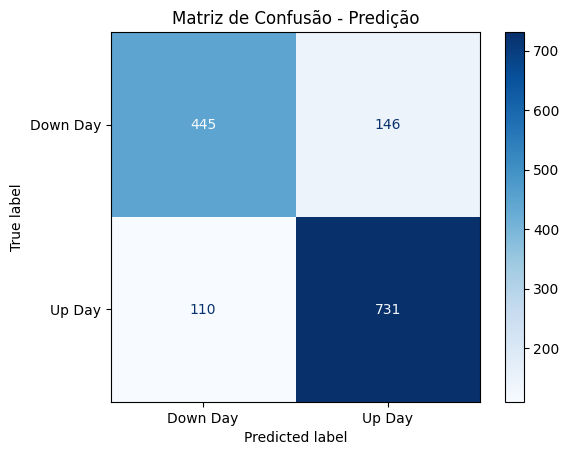

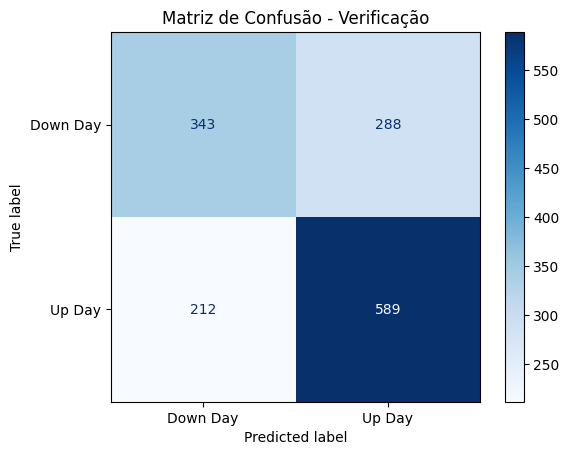

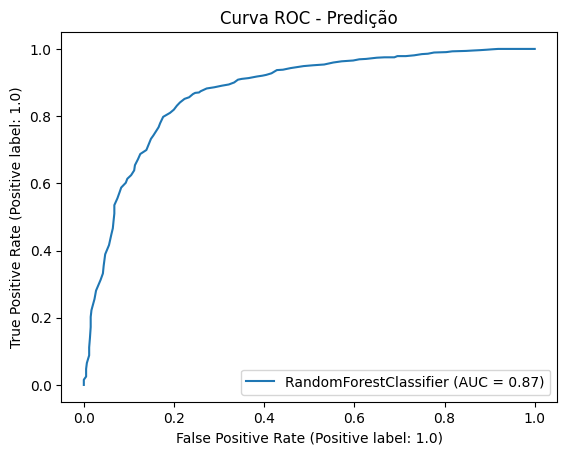

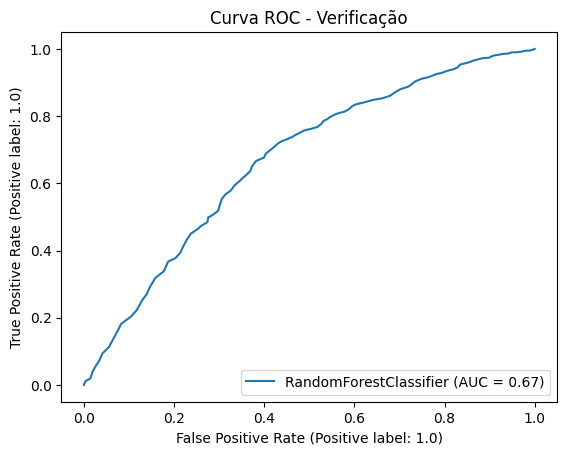

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_ABEV['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_ABEV['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Ambev.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Ambev.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Ambev, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para AMBEV.

In [449]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Ambev, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Ambev.pkl']

#### Carregar modelo. Geralmente carrego do modelo aprendido geral.

In [ ]:
# Carregar o modelo salvo
rand_frst_clf_Ambev = joblib.load('C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model.pkl')

#### Utilizando a verificação da predicação com o preço real e não suavizado.

In [28]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_ABEV[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_ABEV['Prediction'] = np.NaN  # Inicializando a coluna
price_data_ABEV['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_ABEV['Match'] = (price_data_ABEV['Prediction'] == price_data_ABEV['Verify']).astype(int)
overall_accuracy = price_data_ABEV['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_ABEV[price_data_ABEV['Date'] >= price_data_ABEV['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Ambev.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 72.64%

Precisão do modelo nos últimos 30 dias: 100.00%


#### Plotagem:

In [29]:
price_data_ABEV = price_data[price_data['Ticker'].isin(['ABEV3.SA'])]

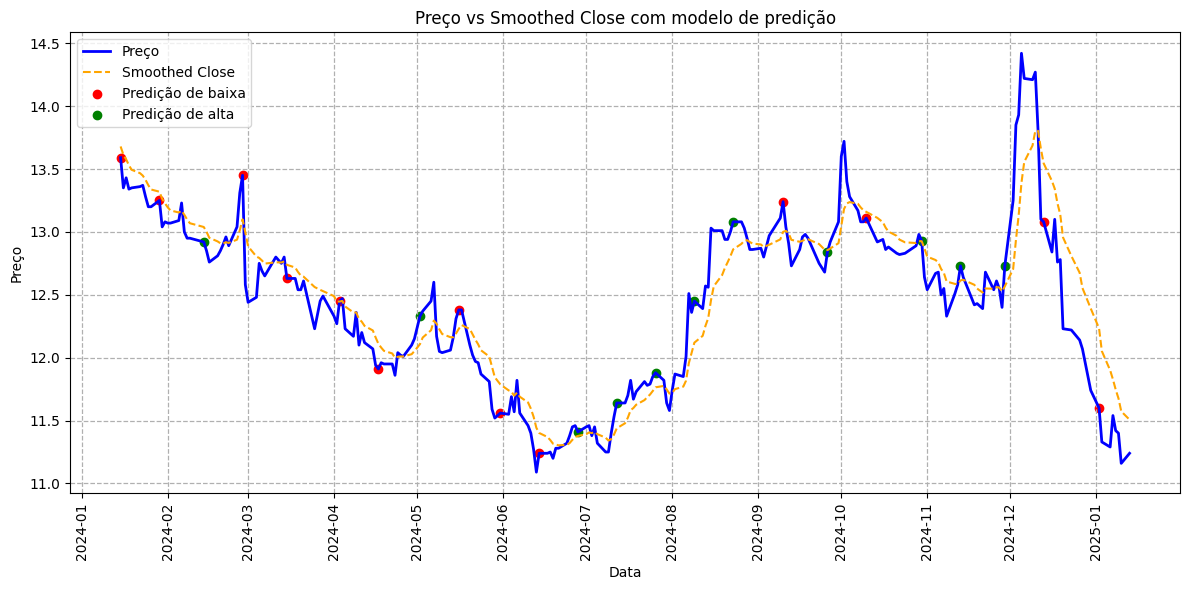

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ABEV3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 10):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### ITAÚ

#### Time series Cross-Validation

In [33]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]
price_data_Itau.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17879,2001-01-15,3.046653,3.112885,3.046653,3.112885,1.785816,7959945,ITUB4.SA,0.032785,3.086218,1.0,3.112885,-1.0,3.079769,3.144234,0.0,0.032785,59.382961,2.790006,3.228790,67.507441,-32.492559,0.019378,-0.001732,0.042447,661183581,0
17880,2001-01-16,3.112885,3.146001,3.096327,3.129443,1.795315,26138577,ITUB4.SA,0.016558,3.094863,1.0,3.129443,-1.0,3.088048,3.132997,0.0,0.016558,61.800980,2.790006,3.228790,69.477662,-30.522338,0.020585,0.002731,0.054508,687322158,0
17881,2001-01-17,3.129443,3.179117,3.104606,3.154280,1.809565,52977726,ITUB4.SA,0.024837,3.106746,1.0,3.154280,-1.0,3.030096,3.112417,0.0,0.024837,65.369227,2.831401,3.228790,69.288587,-30.711413,0.021985,0.006582,0.066075,740299884,0
17882,2001-01-18,3.154280,3.261906,3.154280,3.261906,1.871306,141660459,ITUB4.SA,0.107626,3.137778,-1.0,3.261906,-1.0,3.046653,3.099264,0.0,0.107626,76.394363,2.864351,3.261906,68.777217,-31.222783,0.024745,0.010215,0.075746,881960343,1
17883,2001-01-19,3.261741,3.377811,3.245348,3.328138,1.909304,112526333,ITUB4.SA,0.066232,3.175850,-1.0,3.328138,-1.0,2.972143,3.073840,0.0,0.066232,80.746737,2.905911,3.377811,57.202634,-42.797366,0.029006,0.013973,0.077979,994486676,1


In [34]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Itau.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5835
  Accuracy with Verify: 0.5639
Fold 2:
  Accuracy with Y_test (Prediction): 0.5175
  Accuracy with Verify: 0.5103
Fold 3:
  Accuracy with Y_test (Prediction): 0.6134
  Accuracy with Verify: 0.4866
Fold 4:
  Accuracy with Y_test (Prediction): 0.6000
  Accuracy with Verify: 0.5340
Fold 5:
  Accuracy with Y_test (Prediction): 0.7216
  Accuracy with Verify: 0.5577

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.6072
  Média da acurácia com Verify: 0.5305

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
4845        -1.0              1.0     1.0
4846        -1.0              1.0     1.0
4847        -1.0              1.0     1.0
4848        -1.0              1.0     

#### Walk-Forward Validation

In [35]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']

# Variável adicional de verificação
verify = price_data_Itau['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Itau) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Itau.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Itau.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.4722
Window 2:
  Accuracy with Y_test (Prediction): 0.6222
  Accuracy with Verify: 0.5500
Window 3:
  Accuracy with Y_test (Prediction): 0.5833
  Accuracy with Verify: 0.5056
Window 4:
  Accuracy with Y_test (Prediction): 0.5889
  Accuracy with Verify: 0.5056
Window 5:
  Accuracy with Y_test (Prediction): 0.6556
  Accuracy with Verify: 0.6111
Window 6:
  Accuracy with Y_test (Prediction): 0.5722
  Accuracy with Verify: 0.4444
Window 7:
  Accuracy with Y_test (Prediction): 0.6333
  Accuracy with Verify: 0.5278
Window 8:
  Accuracy with Y_test (Prediction): 0.6222
  Accuracy with Verify: 0.6000
Window 9:
  Accuracy with Y_test (Prediction): 0.5056
  Accuracy with Verify: 0.4333
Window 10:
  Accuracy with Y_test (Prediction): 0.4444
  Accuracy with Verify: 0.4111
Window 11:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.5333
Window 12:
  Accuracy with Y_test (Prediction): 0.5444
  Accura

#### Split normal sem cross-validation.

In [37]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

Acurácia com Y_test (Prediction): 0.7706
Acurácia com Verify: 0.5989

Métricas para 'Prediction':
  Acurácia: 0.7706
  Precisão: 0.7813
  Recall: 0.8196
  F1-Score: 0.8000
  Specificidade: 0.7083

Métricas para 'Verify':
  Acurácia: 0.5989
  Precisão: 0.6164
  Recall: 0.6731
  F1-Score: 0.6435
  Specificidade: 0.5126


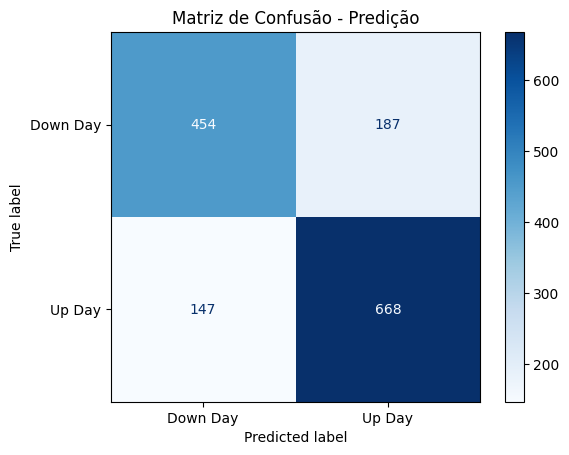

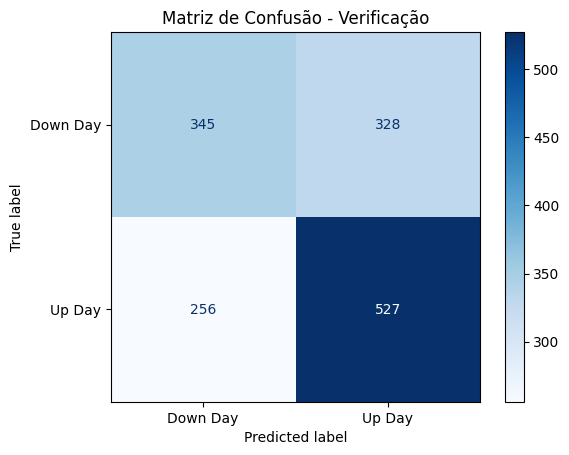

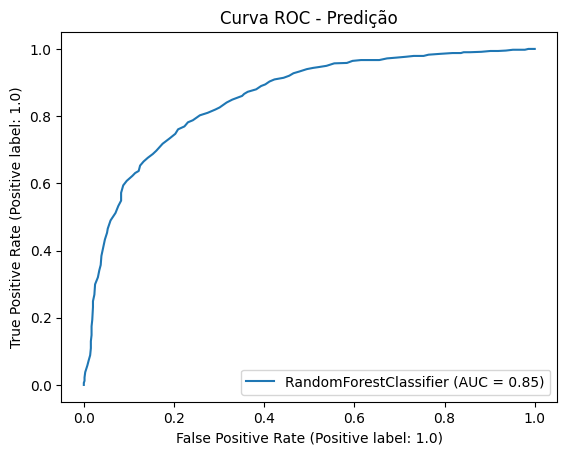

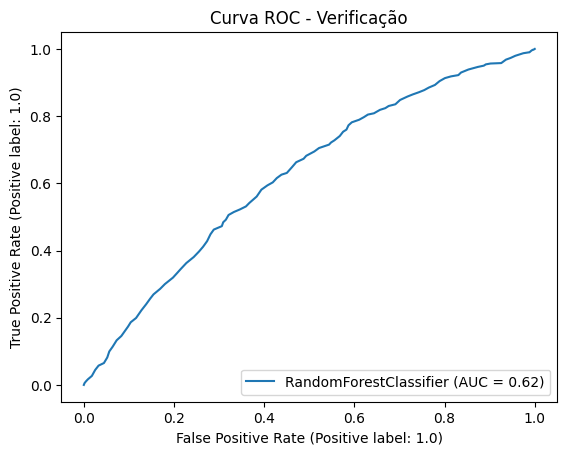

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Itau['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Itau['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Itau = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Itau.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Itau.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Itau.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Itau, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para ITAU.

In [469]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Itau, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Itau.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [111]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Itau[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Itau['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Itau['Prediction'] = rand_frst_clf_Itau.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Itau['Match'] = (price_data_Itau['Prediction'] == price_data_Itau['Verify']).astype(int)
overall_accuracy = price_data_Itau['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Itau[price_data_Itau['Date'] >= price_data_Itau['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Itau.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 52.96%

Precisão do modelo nos últimos 30 dias: 82.35%


#### Plotagem:

In [39]:
price_data_Itau = price_data[price_data['Ticker'].isin(['ITUB4.SA'])]

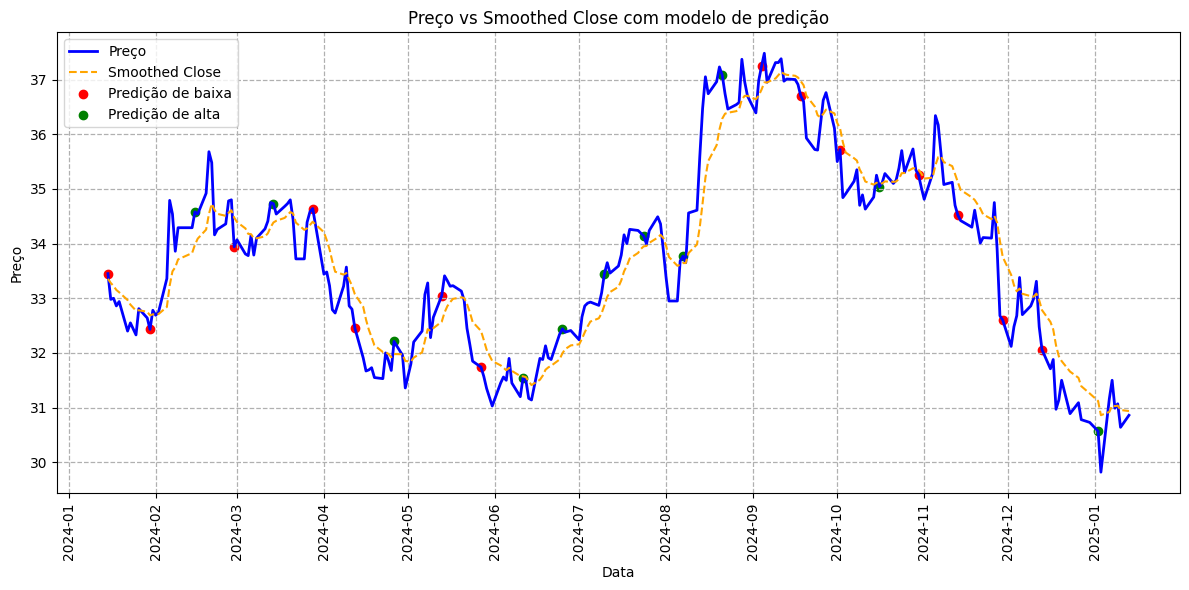

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'ITUB4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 10):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### MAGALU

#### Time series Cross-Validation

In [41]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]
price_data_Magalu.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
23726,2011-05-24,4.662002,4.676616,4.533395,4.580161,4.218390,3585840,MGLU3.SA,-0.061381,4.668944,1.0,4.580161,1.0,4.878295,4.779671,0.061381,0.000000,25.316822,4.533395,4.878295,39.301098,-60.698902,-0.015565,-0.019708,-0.028951,-16798346,1
23727,2011-05-25,4.574315,4.574315,4.439862,4.442785,4.091865,1985366,MGLU3.SA,-0.137376,4.623712,-1.0,4.442785,1.0,4.846144,4.792966,0.137376,0.000000,16.037903,4.439862,4.822760,48.015531,-51.984469,-0.020401,-0.019846,-0.036602,-18783712,0
23728,2011-05-26,4.436940,4.603544,4.436940,4.597698,4.234542,1263135,MGLU3.SA,0.154913,4.618510,1.0,4.597698,1.0,4.998134,4.834000,0.000000,0.154913,43.149183,4.436940,4.822760,47.060661,-52.939339,-0.024157,-0.020708,-0.038388,-20046847,1
23729,2011-05-27,4.556778,4.647387,4.536318,4.618158,4.253386,1778037,MGLU3.SA,0.020460,4.618439,1.0,4.618158,1.0,5.012748,4.869749,0.000000,0.020460,45.815425,4.436940,4.822760,47.042428,-52.957572,-0.026742,-0.021915,-0.037794,-21824884,1
23730,2011-05-30,4.559701,4.670770,4.559701,4.662002,4.293766,498480,MGLU3.SA,0.043844,4.627152,1.0,4.662002,1.0,5.056591,4.907118,0.000000,0.043844,51.445966,4.436940,4.822760,49.300624,-50.699376,-0.027845,-0.023101,-0.034078,-21326404,1


In [42]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Magalu.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5572
  Accuracy with Verify: 0.4773
Fold 2:
  Accuracy with Y_test (Prediction): 0.5263
  Accuracy with Verify: 0.4501
Fold 3:
  Accuracy with Y_test (Prediction): 0.6443
  Accuracy with Verify: 0.5644
Fold 4:
  Accuracy with Y_test (Prediction): 0.5826
  Accuracy with Verify: 0.4846
Fold 5:
  Accuracy with Y_test (Prediction): 0.6425
  Accuracy with Verify: 0.4483

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5906
  Média da acurácia com Verify: 0.4849

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2            1.0              1.0     1.0
3            1.0              1.0     1.0
4            1.0              1.0     1.0
...          ...              ...     ...
2750         1.0             -1.0    -1.0
2751         1.0             -1.0    -1.0
2752         1.0             -1.0    -1.0
2753         1.0             -1.0     

#### Walk-Forward Validation

In [43]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

In [44]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']

# Variável adicional de verificação
verify = price_data_Magalu['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Magalu) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Magalu.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Magalu.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6167
  Accuracy with Verify: 0.5889
Window 2:
  Accuracy with Y_test (Prediction): 0.7167
  Accuracy with Verify: 0.6333
Window 3:
  Accuracy with Y_test (Prediction): 0.6111
  Accuracy with Verify: 0.4611
Window 4:
  Accuracy with Y_test (Prediction): 0.7333
  Accuracy with Verify: 0.6944
Window 5:
  Accuracy with Y_test (Prediction): 0.2278
  Accuracy with Verify: 0.2778
Window 6:
  Accuracy with Y_test (Prediction): 0.7833
  Accuracy with Verify: 0.7167
Window 7:
  Accuracy with Y_test (Prediction): 0.4889
  Accuracy with Verify: 0.5056
Window 8:
  Accuracy with Y_test (Prediction): 0.3444
  Accuracy with Verify: 0.3722
Window 9:
  Accuracy with Y_test (Prediction): 0.5056
  Accuracy with Verify: 0.3889
Window 10:
  Accuracy with Y_test (Prediction): 0.6389
  Accuracy with Verify: 0.6222
Window 11:
  Accuracy with Y_test (Prediction): 0.3000
  Accuracy with Verify: 0.3167
Window 12:
  Accuracy with Y_test (Prediction): 0.5667
  Accura

#### Split normal sem cross-validation.

In [45]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

Acurácia com Y_test (Prediction): 0.8114
Acurácia com Verify: 0.6348

Métricas para 'Prediction':
  Acurácia: 0.8114
  Precisão: 0.8069
  Recall: 0.8474
  F1-Score: 0.8267
  Specificidade: 0.7706

Métricas para 'Verify':
  Acurácia: 0.6348
  Precisão: 0.6139
  Recall: 0.6953
  F1-Score: 0.6521
  Specificidade: 0.5762


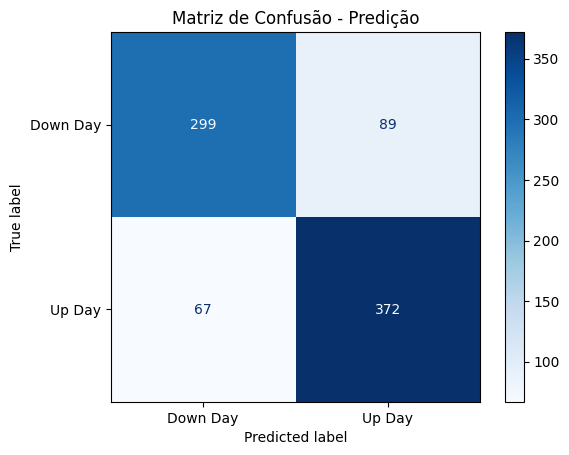

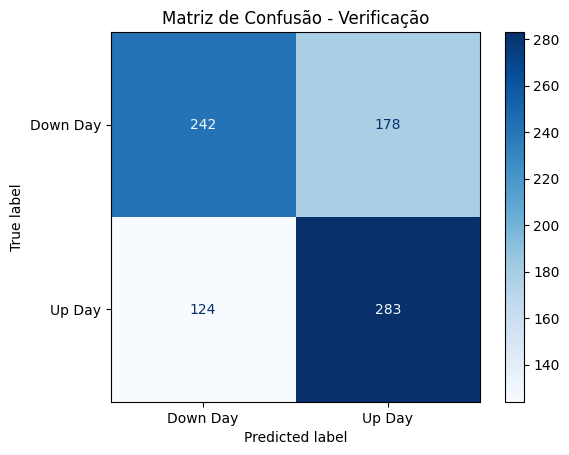

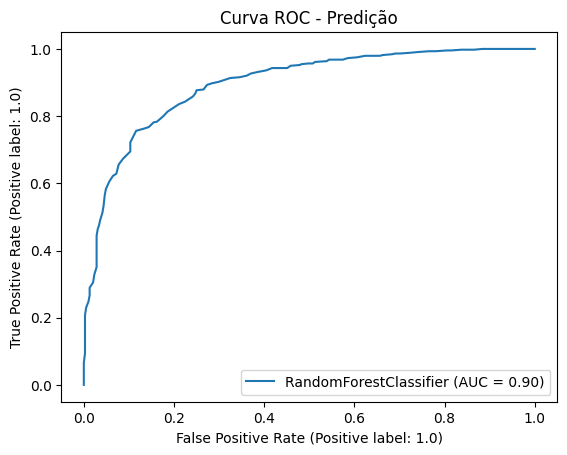

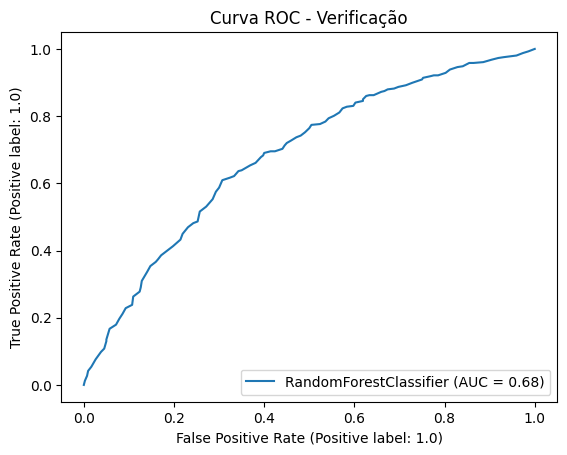

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Magalu['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Magalu['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Magalu = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Magalu.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Magalu.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Magalu.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Magalu, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para MAGALU.

In [481]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Magalu, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Magalu.pkl']

#### Utilizando a verificação da predição com o preço real e não suavizado. Manter cross-validation.

In [122]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Magalu[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Magalu['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Magalu['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Magalu['Match'] = (price_data_Magalu['Prediction'] == price_data_Magalu['Verify']).astype(int)
overall_accuracy = price_data_Magalu['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Magalu[price_data_Magalu['Date'] >= price_data_Magalu['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Magalu.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 74.12%

Precisão do modelo nos últimos 30 dias: 78.95%


#### Plotagem:

In [47]:
price_data_Magalu = price_data[price_data['Ticker'].isin(['MGLU3.SA'])]

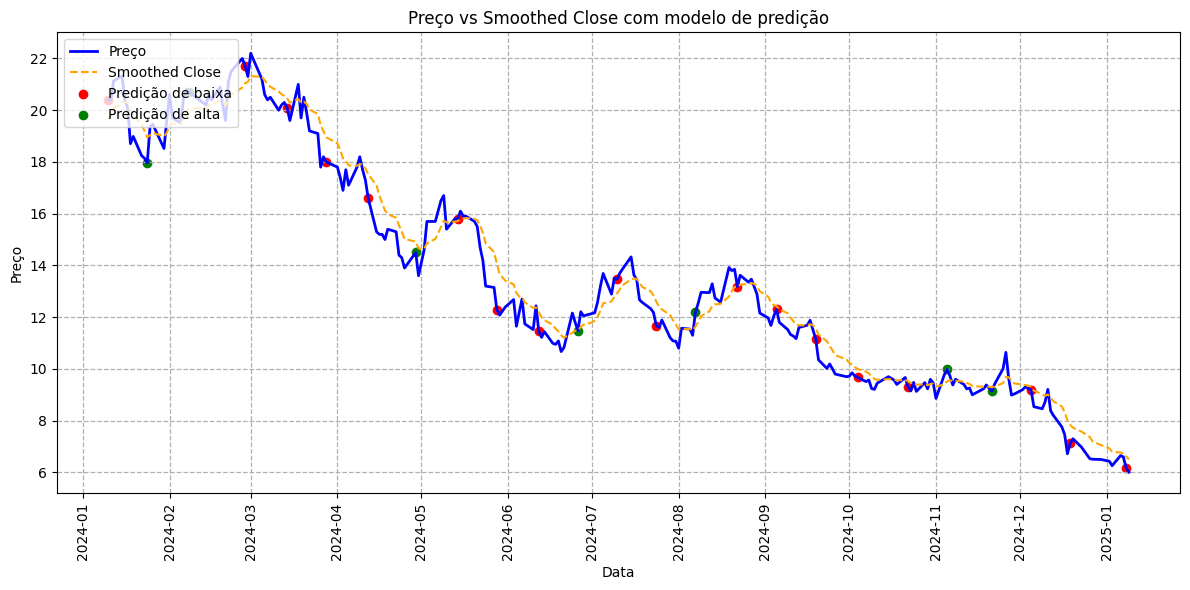

In [48]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'MGLU3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 10):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Petrobrás.

#### Time series Cross-Validation

In [49]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]
price_data_Petro.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
17850,2025-01-07,36.549999,37.250000,36.299999,36.980000,36.980000,37753300,PETR4.SA,0.770000,36.700821,1.0,36.980000,1.0,37.299999,37.104151,0.000000,0.770000,50.007881,35.599998,38.730000,35.170049,-64.829951,-0.337722,-0.071649,-0.068425,-150971652551,1
17851,2025-01-08,36.990002,37.119999,36.430000,36.680000,36.680000,24483500,PETR4.SA,-0.299999,36.696657,1.0,36.680000,1.0,37.090000,37.101321,0.299999,0.000000,45.613435,35.599998,38.490002,37.946626,-62.053374,-0.362933,-0.129906,-0.062359,-150996136051,1
17852,2025-01-09,36.700001,36.970001,36.700001,36.840000,36.840000,11526600,PETR4.SA,0.160000,36.725326,1.0,36.840000,-1.0,36.830002,37.047057,0.000000,0.160000,48.403615,35.599998,38.490002,38.938618,-61.061382,-0.376262,-0.179177,-0.055850,-150984609451,0
17853,2025-01-10,37.250000,37.520000,36.900002,36.939999,36.939999,40328800,PETR4.SA,0.099998,36.768260,1.0,36.939999,-1.0,36.639999,36.965646,0.000000,0.099998,50.244405,35.599998,38.400002,41.723593,-58.276407,-0.378992,-0.219140,-0.051832,-150944280651,0
17854,2025-01-13,37.299999,37.529999,36.970001,37.070000,37.070000,22897100,PETR4.SA,0.130001,36.828608,1.0,37.070000,-1.0,36.810001,36.934517,0.000000,0.130001,52.771882,35.599998,37.930000,52.729990,-47.270010,-0.371997,-0.249711,-0.043029,-150921383551,0


In [50]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Petro.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.4936
  Accuracy with Verify: 0.4767
Fold 2:
  Accuracy with Y_test (Prediction): 0.5382
  Accuracy with Verify: 0.4668
Fold 3:
  Accuracy with Y_test (Prediction): 0.6729
  Accuracy with Verify: 0.5183
Fold 4:
  Accuracy with Y_test (Prediction): 0.6115
  Accuracy with Verify: 0.5104
Fold 5:
  Accuracy with Y_test (Prediction): 0.6670
  Accuracy with Verify: 0.4638

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.5966
  Média da acurácia com Verify: 0.4872

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0    -1.0
2           -1.0              1.0    -1.0
3           -1.0              1.0    -1.0
4           -1.0              1.0    -1.0
...          ...              ...     ...
5040         1.0              1.0     1.0
5041         1.0              1.0     1.0
5042        -1.0              1.0    -1.0
5043         1.0              1.0    -

#### Walk-Forward Validation

In [51]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']

# Variável adicional de verificação
verify = price_data_Petro['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Petro) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Petro.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Petro.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6944
  Accuracy with Verify: 0.5889
Window 2:
  Accuracy with Y_test (Prediction): 0.5278
  Accuracy with Verify: 0.4778
Window 3:
  Accuracy with Y_test (Prediction): 0.5722
  Accuracy with Verify: 0.5444
Window 4:
  Accuracy with Y_test (Prediction): 0.5611
  Accuracy with Verify: 0.5056
Window 5:
  Accuracy with Y_test (Prediction): 0.4889
  Accuracy with Verify: 0.5500
Window 6:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.5167
Window 7:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.6000
Window 8:
  Accuracy with Y_test (Prediction): 0.7444
  Accuracy with Verify: 0.6056
Window 9:
  Accuracy with Y_test (Prediction): 0.6167
  Accuracy with Verify: 0.5556
Window 10:
  Accuracy with Y_test (Prediction): 0.5444
  Accuracy with Verify: 0.5944
Window 11:
  Accuracy with Y_test (Prediction): 0.5778
  Accuracy with Verify: 0.3833
Window 12:
  Accuracy with Y_test (Prediction): 0.7278
  Accura

#### Split normal sem cross-validation.

In [53]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

Acurácia com Y_test (Prediction): 0.7921
Acurácia com Verify: 0.6099

Métricas para 'Prediction':
  Acurácia: 0.7921
  Precisão: 0.8048
  Recall: 0.8322
  F1-Score: 0.8182
  Specificidade: 0.7406

Métricas para 'Verify':
  Acurácia: 0.6099
  Precisão: 0.6118
  Recall: 0.6840
  F1-Score: 0.6459
  Specificidade: 0.5296


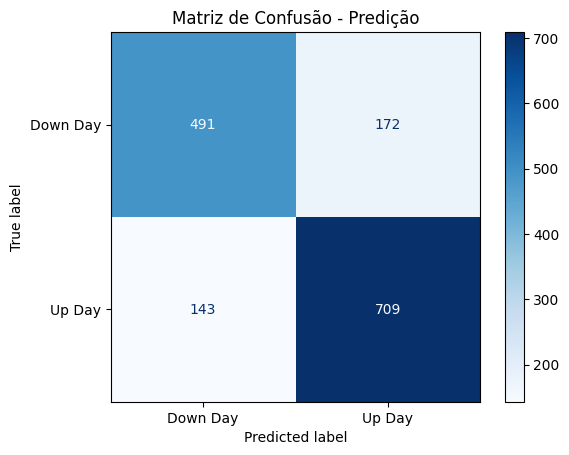

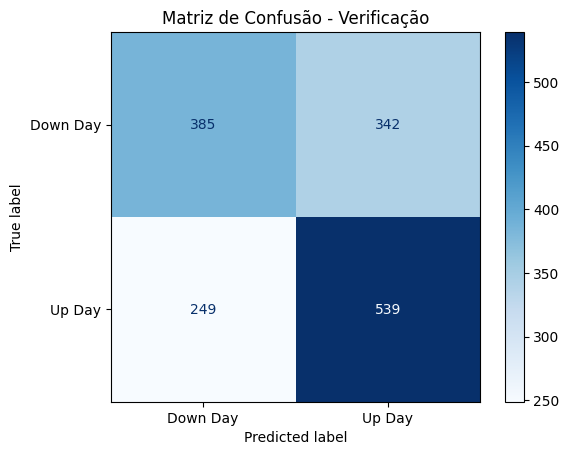

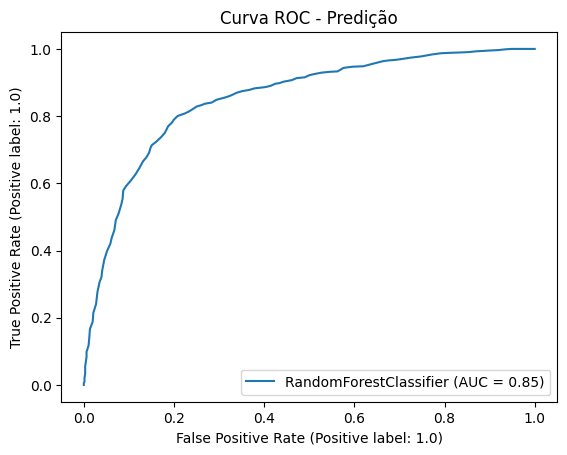

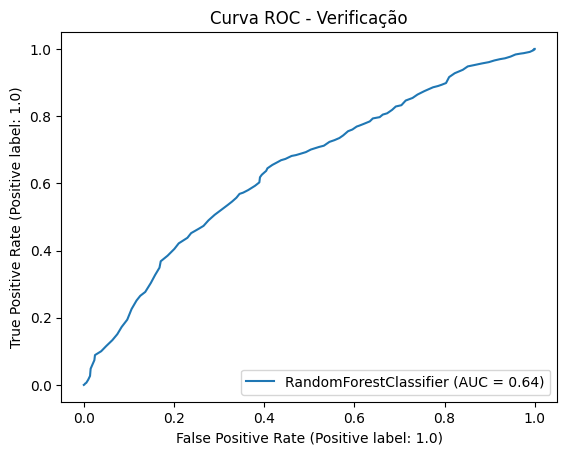

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Petro['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Petro['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Petro = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Petro.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Petro.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Petro.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Petro, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Petrobras.

In [492]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Petro, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Petro.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [134]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Petro[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Petro['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Petro['Prediction'] = rand_frst_clf_Petro.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Petro['Match'] = (price_data_Petro['Prediction'] == price_data_Petro['Verify']).astype(int)
overall_accuracy = price_data_Petro['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Petro[price_data_Petro['Date'] >= price_data_Petro['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Petro.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 71.90%

Precisão do modelo nos últimos 30 dias: 58.82%


#### Plotagem:

In [55]:
price_data_Petro = price_data[price_data['Ticker'].isin(['PETR4.SA'])]

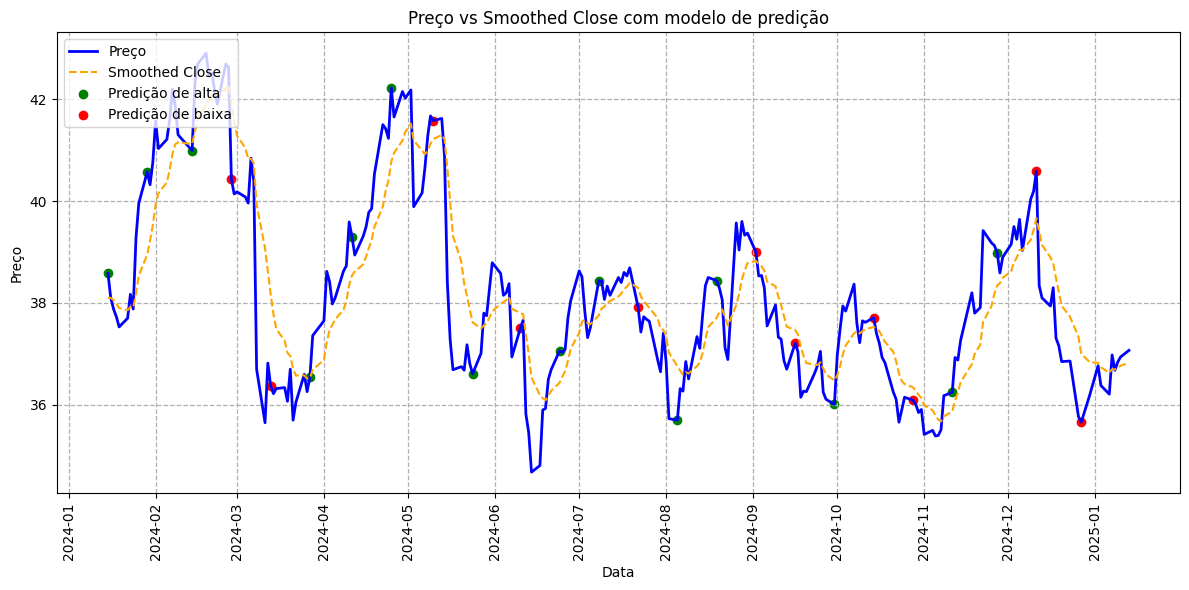

In [56]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'PETR4.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 10):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()


### Vale.

#### Time series Cross-Validation

In [57]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]
price_data_Vale.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Ticker,change_in_price,Smoothed_Close,Prediction,Smoothed_Close_1,Verify,Close_10,Smoothed_Close_10,down_days,up_days,RSI,low_14,high_14,k_percent_14,r_percent_14,MACD,MACD_EMA,Price_Rate_Of_Change,On Balance Volume,Match
5765,2000-01-26,3.966666,3.966666,3.966666,3.966666,1.727176,196800,VALE3.SA,0.050000,3.945435,1.0,3.966666,-1.0,3.790833,3.990499,0.000000,0.050000,60.156173,3.375000,4.166666,72.054990,-27.945010,0.057228,0.032382,0.127267,21297600,0
5766,2000-01-28,4.000000,4.000000,4.000000,4.000000,1.741691,211200,VALE3.SA,0.033334,3.956348,-1.0,4.000000,-1.0,3.741666,3.940732,0.000000,0.033334,63.199074,3.375000,4.166666,73.433478,-26.566522,0.058332,0.037572,0.135794,21508800,1
5767,2000-02-01,3.916666,3.916666,3.916666,3.916666,1.705405,148800,VALE3.SA,-0.083334,3.948412,-1.0,3.916666,-1.0,3.833333,3.919252,0.083334,0.000000,51.789901,3.458333,4.166666,69.187586,-30.812414,0.057959,0.041649,0.137871,21360000,1
5768,2000-02-02,3.950000,3.950000,3.750000,3.750000,1.632835,739200,VALE3.SA,-0.166666,3.908729,1.0,3.750000,1.0,3.833333,3.902068,0.166666,0.000000,36.559368,3.750000,4.166666,38.095072,-61.904928,0.054460,0.044212,0.121801,20620800,1
5769,2000-02-03,3.708333,3.833333,3.708333,3.750000,1.632835,4382400,VALE3.SA,0.000000,3.876983,-1.0,3.750000,-1.0,3.750000,3.871655,0.000000,0.000000,36.559368,3.708333,4.166666,36.796468,-63.203532,0.049072,0.045184,0.090838,16238400,1


In [58]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Preparando as colunas de treino
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Criando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Time Series Split: Número de divisões
tscv = TimeSeriesSplit(n_splits=5)

# Inicializando variáveis para armazenar resultados
fold = 1
report_dict = {}
accuracy_scores_ytest = []
accuracy_scores_verify = []
predictions = []
verify_values = []
actual_y_test_values = []

for train_index, test_index in tscv.split(X_Cols):
    print(f"Fold {fold}:")
    
    # Dividindo os dados em treino e teste para a divisão atual
    X_train, X_test = X_Cols.iloc[train_index], X_Cols.iloc[test_index]
    y_train, y_test = Y_Cols.iloc[train_index], Y_Cols.iloc[test_index]
    y_verify = verify.iloc[test_index]
    
    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)
    
    # Fazendo predições
    y_pred = rand_frst_clf_Vale.predict(X_test)
    
    # Armazenando predições e valores reais
    predictions.extend(y_pred)
    verify_values.extend(y_verify.values)
    actual_y_test_values.extend(y_test.values)
    
    # Calculando acurácias
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)
    
    # Exibindo acurácias para o fold atual
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")
    
    # Gerando o relatório de classificação
    target_names = ['Down Day', 'Up Day']  # Ajuste se necessário
    report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names, output_dict=True)
    
    # Convertendo o relatório em DataFrame
    report_flat = pd.DataFrame(report).transpose()
    report_flat['accuracy_ytest'] = accuracy_ytest
    report_flat['accuracy_verify'] = accuracy_verify
    
    # Armazenando o relatório no dicionário
    report_dict[fold] = report_flat
    fold += 1

# Concatenando os relatórios de todas as divisões
final_report_df = pd.concat(report_dict.values(), keys=report_dict.keys())

# Calculando as médias de acurácia
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

# Exibindo as médias de acurácia
print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo a comparação entre as predições e as variáveis reais
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)

# Exibindo o relatório final
print("\nRelatório Final de Classificação (por Fold):")
print(final_report_df)


Fold 1:
  Accuracy with Y_test (Prediction): 0.5694
  Accuracy with Verify: 0.5285
Fold 2:
  Accuracy with Y_test (Prediction): 0.6773
  Accuracy with Verify: 0.4785
Fold 3:
  Accuracy with Y_test (Prediction): 0.6613
  Accuracy with Verify: 0.5055
Fold 4:
  Accuracy with Y_test (Prediction): 0.6653
  Accuracy with Verify: 0.5025
Fold 5:
  Accuracy with Y_test (Prediction): 0.6833
  Accuracy with Verify: 0.5035

Médias das Acurácias:
  Média da acurácia com Y_test (Prediction): 0.6513
  Média da acurácia com Verify: 0.5037

Comparação:
      Prediction  Y_Test (Actual)  Verify
0            1.0              1.0     1.0
1            1.0              1.0     1.0
2           -1.0              1.0     1.0
3           -1.0              1.0     1.0
4           -1.0              1.0     1.0
...          ...              ...     ...
5000        -1.0             -1.0     1.0
5001        -1.0             -1.0     1.0
5002        -1.0             -1.0     1.0
5003        -1.0             -1.0     

#### Walk-Forward Validation

In [63]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

In [64]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Configurações das janelas
train_window = 365  # 1 ano de dados de treino
test_window = 180   # 6 meses de dados de teste

# Inicializando o modelo Random Forest
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Preparando as colunas de treino (X e Y)
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']

# Variável adicional de verificação
verify = price_data_Vale['Verify']

# Inicializando as variáveis para armazenar resultados
predictions = []
verify_values = []
actual_y_test_values = []
accuracy_scores_ytest = []
accuracy_scores_verify = []

# Realizando o Walk-Forward Validation
for start in range(0, len(price_data_Vale) - train_window - test_window, test_window):
    # Definindo as janelas de treino e teste
    train_start = start
    train_end = start + train_window
    test_start = train_end
    test_end = train_end + test_window

    # Dividindo os dados
    X_train = X_Cols.iloc[train_start:train_end]
    y_train = Y_Cols.iloc[train_start:train_end]
    X_test = X_Cols.iloc[test_start:test_end]
    y_test = Y_Cols.iloc[test_start:test_end]  # Para validar com `Prediction`
    y_verify = verify.iloc[test_start:test_end]  # Para validar com `Verify`

    # Treinando o modelo
    rand_frst_clf_Vale.fit(X_train, y_train)

    # Fazendo predições no período de teste
    y_pred = rand_frst_clf_Vale.predict(X_test)

    # Armazenando resultados
    predictions.extend(y_pred)
    actual_y_test_values.extend(y_test.values)
    verify_values.extend(y_verify.values)

    # Calculando e armazenando a acurácia para esta janela
    accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)
    accuracy_verify = accuracy_score(y_verify, y_pred)  # Comparação com Verify
    accuracy_scores_ytest.append(accuracy_ytest)
    accuracy_scores_verify.append(accuracy_verify)

    print(f"Window {start // test_window + 1}:")
    print(f"  Accuracy with Y_test (Prediction): {accuracy_ytest:.4f}")
    print(f"  Accuracy with Verify: {accuracy_verify:.4f}")

# Calculando as médias das acurácias
overall_accuracy_ytest = sum(accuracy_scores_ytest) / len(accuracy_scores_ytest)
overall_accuracy_verify = sum(accuracy_scores_verify) / len(accuracy_scores_verify)

print("\nMédias das Acurácias:")
print(f"  Média da acurácia com Y_test (Prediction): {overall_accuracy_ytest:.4f}")
print(f"  Média da acurácia com Verify: {overall_accuracy_verify:.4f}")

# Exibindo as comparações de predições com as variáveis 'Y_Cols' e 'Verify'
comparison_df = pd.DataFrame({
    'Prediction': predictions,
    'Y_Test (Actual)': actual_y_test_values,
    'Verify': verify_values
})

print("\nComparação:")
print(comparison_df)


Window 1:
  Accuracy with Y_test (Prediction): 0.6667
  Accuracy with Verify: 0.5389
Window 2:
  Accuracy with Y_test (Prediction): 0.6222
  Accuracy with Verify: 0.5667
Window 3:
  Accuracy with Y_test (Prediction): 0.4667
  Accuracy with Verify: 0.5056
Window 4:
  Accuracy with Y_test (Prediction): 0.4833
  Accuracy with Verify: 0.4389
Window 5:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.6222
Window 6:
  Accuracy with Y_test (Prediction): 0.7778
  Accuracy with Verify: 0.6722
Window 7:
  Accuracy with Y_test (Prediction): 0.5000
  Accuracy with Verify: 0.3722
Window 8:
  Accuracy with Y_test (Prediction): 0.6889
  Accuracy with Verify: 0.5500
Window 9:
  Accuracy with Y_test (Prediction): 0.6278
  Accuracy with Verify: 0.5778
Window 10:
  Accuracy with Y_test (Prediction): 0.6667
  Accuracy with Verify: 0.4611
Window 11:
  Accuracy with Y_test (Prediction): 0.7444
  Accuracy with Verify: 0.5611
Window 12:
  Accuracy with Y_test (Prediction): 0.6333
  Accura

#### Split normal sem cross-validation.

In [61]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

Acurácia com Y_test (Prediction): 0.7804
Acurácia com Verify: 0.5882

Métricas para 'Prediction':
  Acurácia: 0.7804
  Precisão: 0.7825
  Recall: 0.8283
  F1-Score: 0.8047
  Specificidade: 0.7229

Métricas para 'Verify':
  Acurácia: 0.5882
  Precisão: 0.5949
  Recall: 0.6594
  F1-Score: 0.6255
  Specificidade: 0.5104


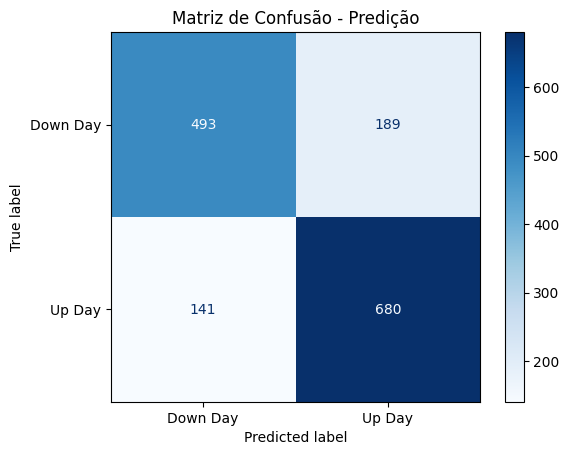

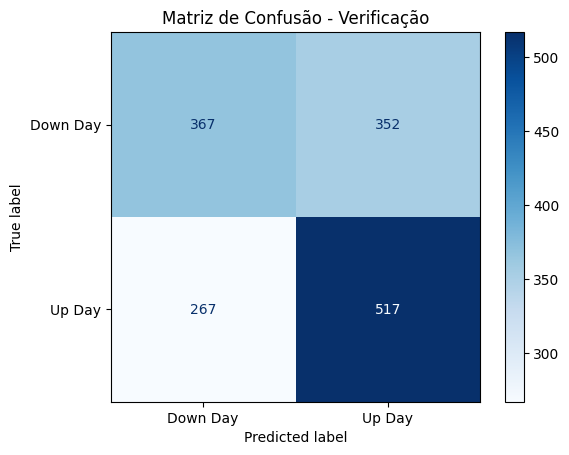

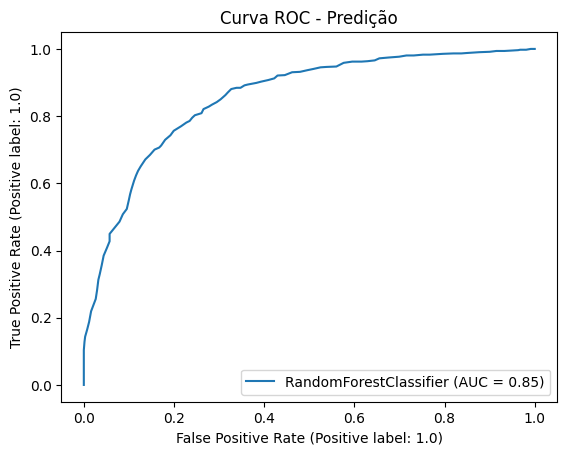

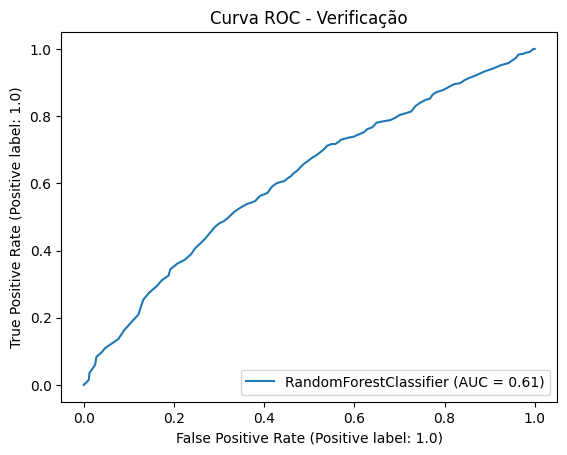

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Definir as colunas X e Y
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = price_data_Vale['Prediction']  # Variável alvo para treinamento com preços suavizados
y_verify = price_data_Vale['Verify']  # Direção do preço real

# Dividir X e Y em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Vale = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Ajustar os dados ao modelo
rand_frst_clf_Vale.fit(X_train, y_train)

# Fazer previsões com a direção de preço suavizada (Prediction)
y_pred = rand_frst_clf_Vale.predict(X_test)

# Calcular a acurácia com base na direção suavizada do preço ('Prediction')
accuracy_ytest = accuracy_score(y_test, y_pred)  # Comparação com Y_Cols (Prediction)

# Alinhar os índices de y_test e y_verify para a comparação correta
accuracy_verify = accuracy_score(y_verify.loc[y_test.index], y_pred)  # Comparação com Verify, usando o mesmo índice de y_test

# Print resultados de acurácia
print(f'Acurácia com Y_test (Prediction): {accuracy_ytest:.4f}')
print(f'Acurácia com Verify: {accuracy_verify:.4f}')

# Função para calcular as métricas adicionais
def calculate_additional_metrics(y_true, y_pred):
    # Calculando a matriz de confusão
    cm = confusion_matrix(y_true, y_pred)
    
    # Extraindo os valores da matriz de confusão
    tn, fp, fn, tp = cm.ravel()  # true_negatives, false_positives, false_negatives, true_positives
    
    # Calculando as métricas
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    recall = recall_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    f1 = f1_score(y_true, y_pred, pos_label=1.0)  # 1.0 para "Up Day"
    specificity = tn / (tn + fp)  # Specificidade
    
    return accuracy, precision, recall, f1, specificity

# Calculando as métricas para 'Prediction' (y_test)
accuracy_pred, precision_pred, recall_pred, f1_pred, specificity_pred = calculate_additional_metrics(y_test, y_pred)

# Calculando as métricas para 'Verify' (y_verify)
y_verify_pred = rand_frst_clf_Vale.predict(X_test)  # As previsões já foram feitas com o modelo
accuracy_verify, precision_verify, recall_verify, f1_verify, specificity_verify = calculate_additional_metrics(y_verify.loc[y_test.index], y_verify_pred)

# Imprimindo as métricas calculadas
print(f"\nMétricas para 'Prediction':")
print(f"  Acurácia: {accuracy_pred:.4f}")
print(f"  Precisão: {precision_pred:.4f}")
print(f"  Recall: {recall_pred:.4f}")
print(f"  F1-Score: {f1_pred:.4f}")
print(f"  Specificidade: {specificity_pred:.4f}")

print(f"\nMétricas para 'Verify':")
print(f"  Acurácia: {accuracy_verify:.4f}")
print(f"  Precisão: {precision_verify:.4f}")
print(f"  Recall: {recall_verify:.4f}")
print(f"  F1-Score: {f1_verify:.4f}")
print(f"  Specificidade: {specificity_verify:.4f}")

# Matriz de Confusão para 'Prediction'
rf_matrix_pred = confusion_matrix(y_test, y_pred)
disp_pred = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_pred, display_labels=['Down Day', 'Up Day'])
disp_pred.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Predição')
plt.show()

# Matriz de Confusão para 'Verify'
rf_matrix_verify = confusion_matrix(y_verify.loc[y_test.index], y_verify_pred)
disp_verify = ConfusionMatrixDisplay(confusion_matrix=rf_matrix_verify, display_labels=['Down Day', 'Up Day'])
disp_verify.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Matriz de Confusão - Verificação')
plt.show()

# Curva ROC para 'Prediction'
rfc_disp_pred = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_test)
plt.title('Curva ROC - Predição')
plt.show()

# Curva ROC para 'Verify'
rfc_disp_verify = RocCurveDisplay.from_estimator(rand_frst_clf_Vale, X_test, y_verify.loc[y_test.index])
plt.title('Curva ROC - Verificação')
plt.show()


#### Salvar modelo aprendido para Vale.

In [504]:
# Salvar o modelo treinado
joblib.dump(rand_frst_clf_Vale, 'C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl')

['C:/Users/Samsung/Documents/GitHub-Datas/TCC_Machine_Learning/random_forest_model_Vale.pkl']

#### Utilizando a verificação da predicação com o preço real e não suavizado. Manter cross-validation.

In [146]:
import warnings
from datetime import timedelta
import numpy as np

# Desativa warnings
warnings.filterwarnings("ignore")

# Selecionar colunas de features (X) e carregar como array NumPy
X_Cols = price_data_Vale[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para todo o dataset
price_data_Vale['Prediction'] = np.NaN  # Inicializando a coluna
price_data_Vale['Prediction'] = rand_frst_clf_Vale.predict(X_Cols)

# Comparar as predições com a variável 'Verify' para o conjunto completo
price_data_Vale['Match'] = (price_data_Vale['Prediction'] == price_data_Vale['Verify']).astype(int)
overall_accuracy = price_data_Vale['Match'].mean()  # Proporção de acertos no dataset completo

print(f"\nPrecisão do modelo para todo o dataset: {overall_accuracy:.2%}")

# Filtrar os últimos 30 dias
last_30_days = price_data_Vale[price_data_Vale['Date'] >= price_data_Vale['Date'].max() - timedelta(days=30)]

# Selecionar colunas de features (X) para os últimos 30 dias
X_Cols_last_30 = last_30_days[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']].values

# Gerar previsões para os últimos 30 dias
last_30_days['Prediction'] = rand_frst_clf_Vale.predict(X_Cols_last_30)

# Comparar as predições com 'Verify' nos últimos 30 dias
last_30_days['Match'] = (last_30_days['Prediction'] == last_30_days['Verify']).astype(int)
accuracy_last_30_days = last_30_days['Match'].mean()  # Proporção de acertos nos últimos 30 dias

print(f"\nPrecisão do modelo nos últimos 30 dias: {accuracy_last_30_days:.2%}")




Precisão do modelo para todo o dataset: 71.38%

Precisão do modelo nos últimos 30 dias: 52.94%


#### Plotagem:

In [65]:
price_data_Vale = price_data[price_data['Ticker'].isin(['VALE3.SA'])]

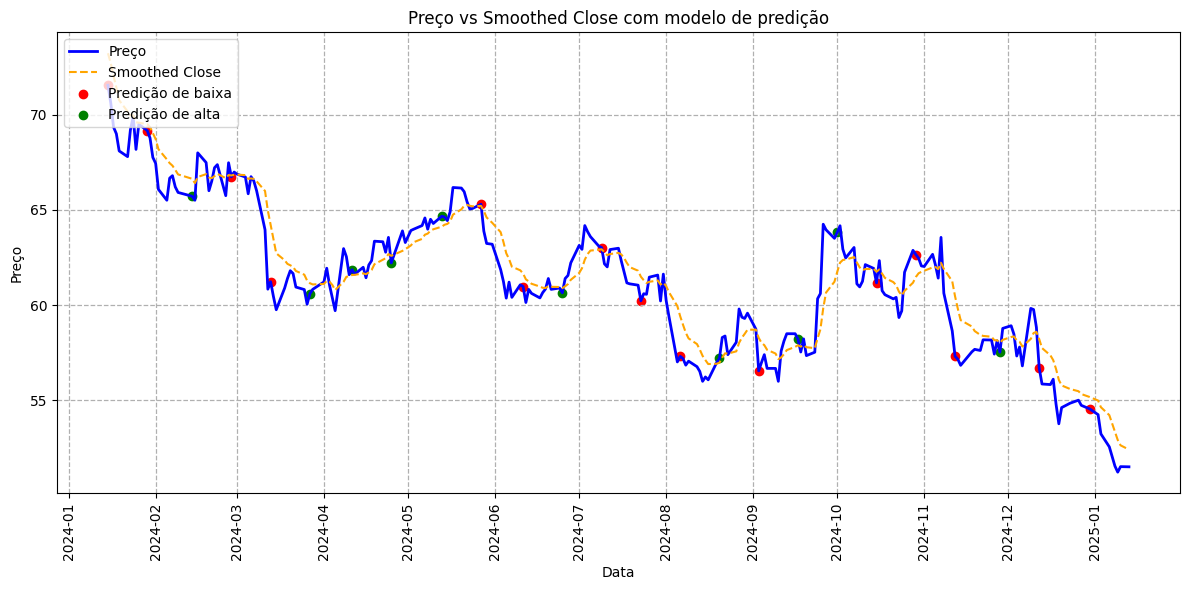

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates

# Filtrando os dados para o último ano
ticker_data = price_data[price_data['Ticker'] == 'VALE3.SA'][['Date', 'Close', 'Smoothed_Close', 'Prediction', 'RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]

# Converter a coluna 'Date' para formato datetime, se necessário
ticker_data['Date'] = pd.to_datetime(ticker_data['Date'])

# Filtrar para o período de 1 ano (últimos 365 dias)
one_year_data = ticker_data[ticker_data['Date'] >= ticker_data['Date'].max() - pd.Timedelta(days=365)]

# Separando os dados para as colunas X e Y (usando os indicadores)
X_Cols = one_year_data[['RSI', f'k_percent_{t}', f'r_percent_{t}', 'Price_Rate_Of_Change', 'MACD', 'MACD_EMA', 'On Balance Volume']]
Y_Cols = one_year_data['Prediction']

# Split X and Y para treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_Cols, Y_Cols, random_state=0)

# Criar o modelo Random Forest Classifier
rand_frst_clf_Ambev = RandomForestClassifier(n_estimators=100, oob_score=True, criterion="gini", random_state=0)

# Treinar o modelo
rand_frst_clf_Ambev.fit(X_train, y_train)

# Fazer previsões para os dados reais de 1 ano (agora usando o modelo treinado)
y_pred = rand_frst_clf_Ambev.predict(X_Cols)

# Criando a figura
plt.figure(figsize=(12, 6))

# Plotando Close e Smoothed_Close
plt.plot(one_year_data["Date"], one_year_data["Close"], label="Preço", color="blue", linewidth=2)
plt.plot(one_year_data["Date"], one_year_data["Smoothed_Close"], label="Smoothed Close", color="orange", linestyle="--")

# Adicionando sinais de Prediction (usando o modelo para prever sinais)
scatter_plotted = {"green": False, "red": False}  # Para controlar a legenda
for i in range(0, len(one_year_data), 10):  # A cada 5 dias
    color = "green" if y_pred[i] == 1 else "red"  # Se previsão for 1, sinal verde, senão sinal vermelho
    label = "Predição de alta" if color == "green" else "Predição de baixa"

    # Para evitar repetição da legenda, plota uma vez cada cor
    if not scatter_plotted[color]:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color, label=label)
        scatter_plotted[color] = True
    else:
        plt.scatter(one_year_data["Date"].iloc[i], one_year_data["Close"].iloc[i], color=color)

# Configurações finais do gráfico
plt.xlabel("Data")
plt.ylabel("Preço")
plt.title("Preço vs Smoothed Close com modelo de predição")
plt.legend(loc='upper left')
plt.grid(True, which="both", linestyle="--", linewidth=0.9)
plt.xticks(rotation=90)  # Rotaciona as datas para facilitar a leitura
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Exibe mais meses no eixo X

plt.tight_layout()  # Ajusta para evitar sobreposição
plt.show()
